# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [45]:
# Do relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from decimal import Decimal
import math

%matplotlib inline

#XXX: global vars
#List to keep vanishing points
van_points = []
left_lane_slopes = []
right_lane_slopes = []

# Some draw/visualise state flags
# Draw Hough Transfor lines
DHLINES = False
# Draw Vanishing point circle
DVPOINT = False
#Draw lane detection region mask polygon
DLMASK = False

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


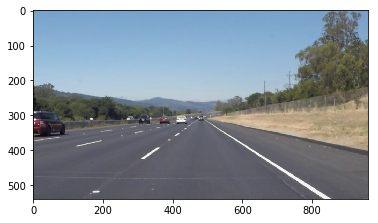

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [22]:
#Find intersection of 2 lines
def findIntersection(line1, line2):
    
    a = np.array([[(line1[0]*-1),1], [(line2[0]*-1),1]])
    b = np.array([line1[1],line2[1]])
    x = np.linalg.solve(a, b)
    
    return x

# Function returns line parameters from two points on same line
def lin_equ(t1,t2):
    #points encoded as t=[x,y]
    
    m=(( t2[1] - t1[1] )) / ( t2[0] - t1[0] )
    c=( t2[1] - ( m * t2[0] ))
    return m, c

# Function converts image to grayscale
def grayer(image):
    # Read in and grayscale the image
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    return gray

# Function return Canny edges with fixed input params:
# XXX: function should take in all parameters
def smoothCanny(gray):
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 100
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    return edges

# Function masks out unwanted region
def masker(edges, mask_vertices):
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255

    # This time we are defining a four sided polygon to mask
    cv2.fillPoly(mask, mask_vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    return masked_edges

# Function performs cv2.HoughLinesP on fixed parameters and returns detected lines
def hLines(edges):
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 #minimum number of pixels making up a line
    max_line_gap = 140    # maximum gap in pixels between connectable line segments
    
    
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    
    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    
    
    # Test slope parameter (a) of all lines and discard those not in 'relevant' range
    # if (a > 0.4 and a < 0.8) or (a < -0.4 and a > -0.8):
    relevant_lines = []
    a = .0
    b = .0
    
    try:
        for line in lines:
            for x1,y1,x2,y2 in line:
                a, b = lin_equ([x1, y1], [x2, y2])
        
            if (a > 0.4 and a < 0.8) or (a < -0.4 and a > -0.8):
                relevant_lines.append(line)
    except:
        pass
                    

    
    return relevant_lines


def drawLaneLine(line_image, lane_slopes, van_point):
    
    ysize = line_image.shape[0]
    xsize = line_image.shape[1]
    
    slopep = np.median(lane_slopes[-50:], axis=0)
    
    # Calculate x coordinate for lane line
    # x1 is bottom of y axis
    # x2 is 60% of y axis
    x1 = int(van_point[0] + ((ysize - van_point[1]) / slopep))
    x2 = int(van_point[0] + (((ysize * 0.63) - van_point[1]) / slopep))
    
    cv2.line(line_image,(x1,ysize),(x2,int(ysize * 0.63)),(255,0,0),15)
    
    return line_image

# function draws detected lane lines and other supporting artifacts,
# like detection region mask, vanishing point and lines from Hough transform
def drawLines(image, lines, van_point, mask_vertices):
    
    # size of image
    ysize = image.shape[0]
    xsize = image.shape[1]

    line_image = np.copy(image)*0 #creating a blank to draw lines on
    
    
    # Draw vanishing point
    if DVPOINT:
        cv2.circle(line_image, (int(van_point[0]), int(van_point[1])), 20, (255,0,0))
    
    # Draw lane mask boundary
    if DLMASK:
        cv2.polylines(line_image, mask_vertices, 1, (0,0,255), 3)
        
    
    # Iterate over the output "lines" and draw lines on the blank
    try:
        
        if DHLINES:
            # draw lines detected with hough method
            for line in lines:
                for x1,y1,x2,y2 in line:
                    cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),5)
        
        
        left_drawn  = False
        right_drawn = False
        slopep = 0
        
        for line in lines:
            for x1,y1,x2,y2 in line:
                a, b = lin_equ([x1, y1], [x2, y2])
                
                # Separate left from right lines to lists
                # use Median to get more persistance for either left or right list with partial detection
                # and more stable lane line output
                # slope a > 0 => it is possible left lane line
                # slope a < 0 => it is possible right lane line

                
                if a > 0:
                    left_drawn = True
                    left_lane_slopes.append(a)
                    line_image = drawLaneLine(line_image, left_lane_slopes, van_point)
                elif a < 0:
                    right_drawn = True
                    right_lane_slopes.append(a)
                    line_image = drawLaneLine(line_image, right_lane_slopes, van_point)
                else:
                    pass
                
        
        
        # Draw the other line
        if not left_drawn:
            line_image = drawLaneLine(line_image, left_lane_slopes, van_point)
            
        elif not right_drawn:
            line_image = drawLaneLine(line_image, right_lane_slopes, van_point)
        
    except:
        pass
    
    return line_image



def computeIntersections(lines):
    
    intersections = []
    
    left_lane_lines = []
    right_lane_lines = []
    
    # Separate right from left lines of lane
    for line in lines:
        # reset a and b values
        a = .0
        b = .0
        
        # get line parameters
        for x1,y1,x2,y2 in line:
            a, b = lin_equ([x1, y1], [x2, y2])
        
        # based on slope parameter place line in relevant list
        if a > 0:
            left_lane_lines.append(line)
        elif a < 0:
            right_lane_lines.append(line)
        else:
            pass
           
    
    # find right and left lines intersection
    if (not len(left_lane_lines) == 0) and (not len(right_lane_lines) == 0): 
        
        leftline_m  = 0
        leftline_b  = 0
        rightline_m = 0
        rightline_b = 0
        
        for x1,y1,x2,y2 in np.median(left_lane_lines, axis=0):
            leftline_m, leftline_b = lin_equ([x1, y1], [x2, y2])
            
        for x1,y1,x2,y2 in np.median(right_lane_lines, axis=0):
            rightline_m, rightline_b = lin_equ([x1, y1], [x2, y2])
            
            try:
                    intersection = findIntersection([leftline_m, leftline_b], [rightline_m, rightline_b])
                
                    # ovdje treba popraviti da presjek mora biti takodje i manji od maksimalne velicine x i y slike koja se obradjuje
                    if intersection[0] > 0 and intersection[1] > 0:
                        intersections.append(intersection)
                    else:
                        pass
                
            except:
                pass
    else:
        pass

    
    return np.median(intersections, axis=0)
            

# Combine image with detected artifacts
def drawCombi(image, line_image):
    # Draw the lines on the edge image
    combo = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    return combo

def getVanPoint(lines):
    
    #Calculate vanishing point coordinates with lane line intersections
    van_point = computeIntersections(lines)
    
    try:
        if not math.isnan(van_point[0]) and not math.isnan(van_point[1]):
            van_points.append(van_point)
        else:
            pass
    except:
        pass
    
    # Too give more 'weight/gravity' and settle down movement of vanishing point
    # use median across last 20 vanishing point values
    return np.median(van_points[-20:], axis=0)

def process_image(input_image):
    global image
    image = input_image
    
    # Set shape of mask and apply
    # Get sizes of image
    ysize = image.shape[0]
    xsize = image.shape[1]
    
    # Define lane detection mask as percentage of image sizes
    mask_vertices = np.array([[(xsize*0.05, ysize*0.9), \
                          (xsize*0.45, ysize*0.6), \
                          (xsize*0.55, ysize*0.6), \
                          (xsize*0.95, ysize*0.9)]], \
                        dtype=np.int32)
    
    
    # Get edges performing smooth gray and canny operations
    edges = smoothCanny(grayer(image))
    
    # Get Hough Transform lane lines with discarding lines out of relevant slope ranges
    lines = hLines(masker(edges, mask_vertices))
    
    # Using median over intersections of lane lines get vanishing point
    new_van_point = getVanPoint(lines)

    # return combined image with drawn lane lines and other helping graphical artifacts
    return drawCombi(image, drawLines(image, lines, new_van_point, mask_vertices))


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [31]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg']

run your solution on all test_images and make copies into the test_images directory).

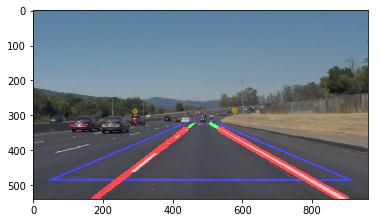

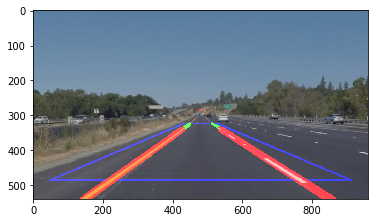

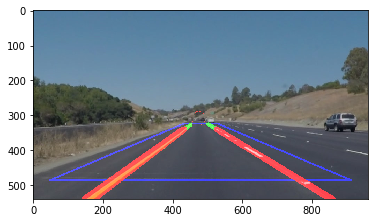

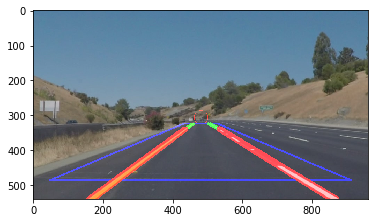

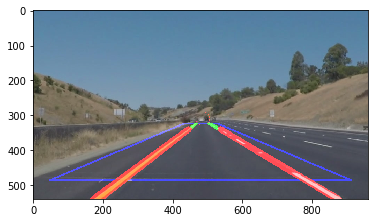

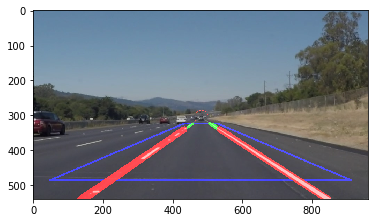

In [44]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
import glob
filepaths = glob.glob('test_images/*.jpg')

for count, filepath in enumerate(filepaths):
    
    #Clean some global var state
    van_points = []
    left_lane_slopes = []
    right_lane_slopes = []
    
    test_image = mpimg.imread(filepath)
    result = process_image(test_image)
    mpimg.imsave(filepath[:-4] + '_solved' + filepath[-4:], result)
    plt.figure(count+1)
    plt.imshow(result)



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
# Method defined before in file
#def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

#    return result

Let's try the one with the solid white lane on the right first ...

In [40]:
#Clean some global var state
van_points = []
left_lane_slopes = []
right_lane_slopes = []

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 47.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 28.2 s, sys: 148 ms, total: 28.4 s
Wall time: 4.88 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
#Clean some global var state
van_points = []
left_lane_slopes = []
right_lane_slopes = []

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:15<00:00, 43.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 33s, sys: 388 ms, total: 1min 33s
Wall time: 15.9 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

---------------
Due to lack of time, it's not nicest/most readable solution. Given more time, I would invest it in refactoring, and optimizing performance. I presume weak points of pipeline are low/lower lane detection performance with increased noise, and proper lane detection with more curvy road. Curve fiting would need to be added. Additional improvements would be to expand detection region and to detect neighbouring lanes.

I've added couple of visual debuging aid that helped me during evaluation of different parameters. These can be disabled at top of file. Red are detected lane lines, green are Hough Transform result lines, Blue is region mask polygon border, and red circle is vanishing point. If necessary I can remove extra elements from some of video output in this file and resubmit project. 


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [24]:
#Clean some global var state
van_points = []
left_lane_slopes = []
right_lane_slopes = []

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:07<00:00, 31.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 38.2 s, sys: 268 ms, total: 38.4 s
Wall time: 8.43 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))